##### Preparing Alpha Factors and Features to predict Stock Returns

##### Imports & Settings

In [287]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [288]:
%matplotlib inline

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

DATA = Path('./data')
DATA_STORE = DATA / 'data.h5'
DATA_READ = DATA / 'assets.h5'

In [289]:
MONTH = 21
YEAR = 12 * MONTH

In [290]:
START = '2013-01-01'
END = '2017-12-31'

In [291]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

##### Loading Quandl Wiki Stock Prices & Meta Data

In [292]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [293]:
with pd.HDFStore(DATA_READ) as store:
    prices = (store['quandl/wiki/prices'] # prices
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['us_equities/stocks'] # metadata
              .loc[:, ['market_cap', 'ipo_year', 'sector']])

##### Remove stocks with few observations

In [294]:
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

##### Align price and meta data

In [295]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 999811 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    999697 non-null  float64
 1   close   999811 non-null  float64
 2   low     999811 non-null  float64
 3   high    999811 non-null  float64
 4   volume  999811 non-null  float64
dtypes: float64(5)
memory usage: 42.7+ MB


In [296]:
stocks.sector.value_counts()

consumer_discretionary    214
technology                139
finance                   119
health_care               111
industrials               105
real_estate                56
energy                     25
utilities                  18
consumer_staples           13
telecommunications         11
basic_materials             6
miscellaneous               5
Name: sector, dtype: int64

##### Compute Rolling Average Dollar Volume

In [297]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

In [298]:
# Step 1: Calculate the rolling mean for each ticker
rolling_mean = prices.groupby('ticker')['dollar_vol'].rolling(window=21).mean()

# Step 2: Reset the index
rolling_mean = rolling_mean.reset_index(level=0, drop=True)

# Step 3: Join the rolling mean result back to the prices DataFrame
prices['dollar_vol_1m'] = rolling_mean

prices.dropna(subset=['dollar_vol_1m'], inplace=True)

In [299]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False)) 

In [300]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 983371 entries, ('A', Timestamp('2013-01-31 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             983257 non-null  float64
 1   close            983371 non-null  float64
 2   low              983371 non-null  float64
 3   high             983371 non-null  float64
 4   volume           983371 non-null  float64
 5   dollar_vol       983371 non-null  float64
 6   dollar_vol_1m    983371 non-null  float64
 7   dollar_vol_rank  983371 non-null  float64
dtypes: float64(8)
memory usage: 64.5+ MB


##### Add some Basic Factors

##### Compute the Relative Strength Index

In [301]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

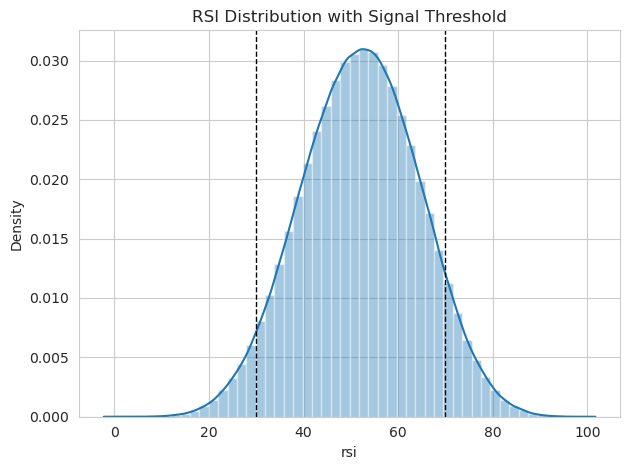

In [302]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()

##### Compute Bollinger Bands

In [303]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [304]:
prices = (prices.join(prices
            .groupby(level='ticker')
            .close
            .apply(compute_bb))).dropna()

In [305]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

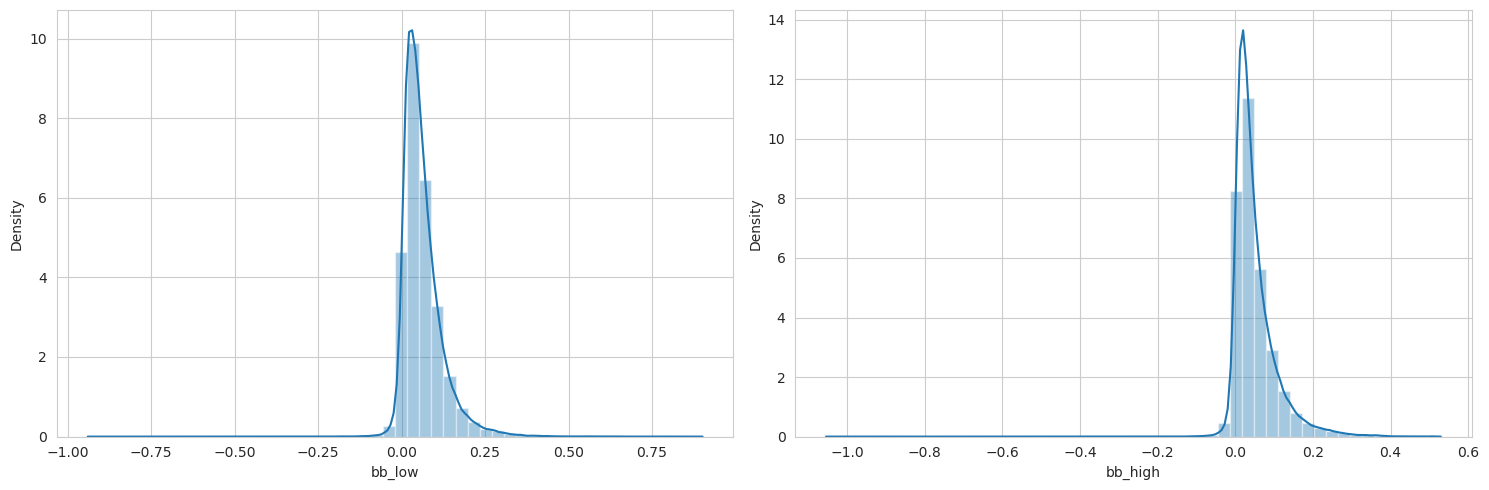

In [306]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout()

##### Compute Average True Range

In [307]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [308]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

<Axes: xlabel='atr', ylabel='Density'>

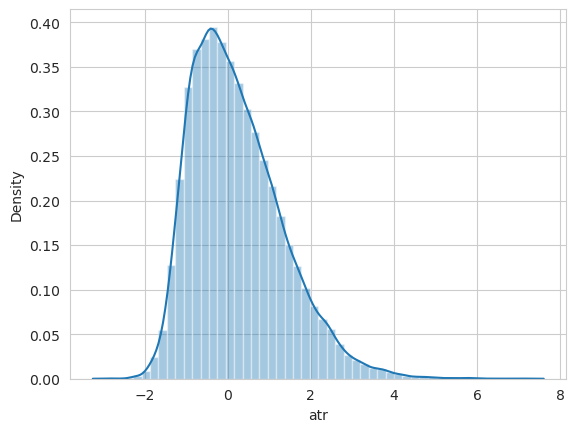

In [309]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna())

##### Compute Moving Average Convergence/Divergence

In [310]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, \
    .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

prices.dropna(subset=['macd'], inplace=True)

<Axes: xlabel='macd', ylabel='Density'>

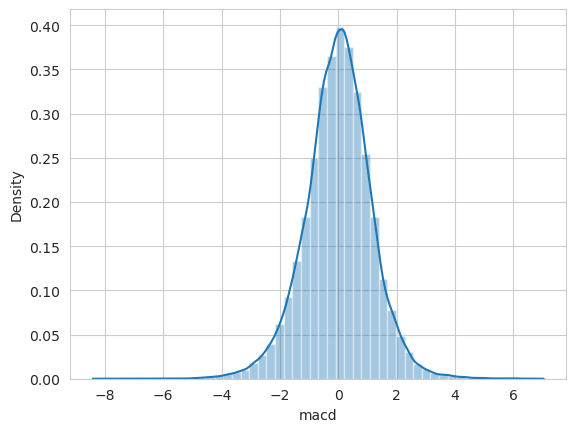

In [311]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna())

##### Compute Lagged Returns

In [312]:
lags = [1, 5, 10, 21, 42, 63]

returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:]\+
    .to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,3.92%
min,-90.60%
0.01%,-35.25%
0.1%,-15.36%
1%,-6.50%
50%,0.04%
99%,7.01%
99.9%,17.39%
99.99%,40.12%
max,"2,588.17%"


##### Winsorize outliers

In [313]:
q = 0.0001

for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

##### Shift lagged returns

In [314]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

prices.dropna(inplace=True)

##### Compute Forward Returns

In [315]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] \
        = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

prices.dropna(inplace=True)

##### Combine Price and Meta Data

In [316]:
prices = prices.join(stocks[['sector']])

##### Create time and sector dummy variables

In [317]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 819669 entries, ('A', Timestamp('2013-10-15 00:00:00')) to ('ZUMZ', Timestamp('2017-11-29 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             819669 non-null  float64
 1   close            819669 non-null  float64
 2   low              819669 non-null  float64
 3   high             819669 non-null  float64
 4   volume           819669 non-null  float64
 5   dollar_vol       819669 non-null  float64
 6   dollar_vol_1m    819669 non-null  float64
 7   dollar_vol_rank  819669 non-null  float64
 8   rsi              819669 non-null  float64
 9   bb_high          819669 non-null  float64
 10  bb_low           819669 non-null  float64
 11  atr              819669 non-null  float64
 12  macd             819669 non-null  float64
 13  return_1d        819669 non-null  float64
 14  return_5d        819669 non-null  float64
 15  return_10d 

In [318]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('model_data/no_dummies', \
        prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]))

In [319]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 819669 entries, ('A', Timestamp('2013-10-15 00:00:00')) to ('ZUMZ', Timestamp('2017-11-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   open                    819669 non-null  float64
 1   close                   819669 non-null  float64
 2   low                     819669 non-null  float64
 3   high                    819669 non-null  float64
 4   volume                  819669 non-null  float64
 5   dollar_vol              819669 non-null  float64
 6   dollar_vol_1m           819669 non-null  float64
 7   dollar_vol_rank         819669 non-null  float64
 8   rsi                     819669 non-null  float64
 9   bb_high                 819669 non-null  float64
 10  bb_low                  819669 non-null  float64
 11  atr                     819669 non-null  float64
 12  macd                    819669 non-null  float64
 13  

In [320]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('model_data', prices)

In [321]:
with pd.HDFStore(DATA_STORE) as store:
    prices = store['model_data']

In [322]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-10-15  35.475549  35.336647  35.142184  35.551945  1961.900   
       2013-10-16  35.572780  35.808913  35.378317  36.107552  2488.000   
       2013-10-17  35.593615  36.565929  35.510274  36.600654  3548.400   
       2013-10-18  36.760391  36.802062  36.552038  36.975689  2880.900   
       2013-10-21  36.836787  36.107552  36.045046  36.906238  2556.400   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-11-22  19.250000  18.600000  18.500000  19.412000   265.795   
       2017-11-24  18.800000  19.050000  18.250000  19.200000   208.610   
       2017-11-27  19.150000  19.200000  18.900000  20.150000   443.388   
       2017-11-28  19.200000  20.100000  19.150000  20.300000   689.911   
       2017-11-29  20.250000  20.850000  20.100000  21.150000   724.964   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-10-15   69326.966985  119617.236061             60.0  54.511115   
       2013-10-16   89092.575827  121314.608805             58.0  58.873489   
       2013-10-17  129750.540826  124166.632218             60.0  64.714824   
       2013-10-18  106023.059812   98691.379372             77.0  66.321683   
       2013-10-21   92305.346511   84689.325626             89.0  57.961247   
...                          ...            ...              ...        ...   
ZUMZ   2017-11-22    4943.787000    5761.835586            526.0  55.097028   
       2017-11-24    3974.020500    5720.920719            524.0  58.668474   
       2017-11-27    8513.049600    5915.601226            519.0  59.815803   
       2017-11-28   13867.211100    6376.928660            513.0  65.927314   
       2017-11-29   15115.499400    6934.407026            507.0  70.019337   

                    bb_high    bb_low       atr      macd  return_1d  \
ticker date                                                            
A      2013-10-15  0.032279  0.021315 -0.710945  0.416303  -0.009346   
       2013-10-16  0.015801  0.025458 -0.655359  0.415920   0.013365   
       2013-10-17 -0.000789  0.045568 -0.444008  0.526098   0.021140   
       2013-10-18 -0.003256  0.053432 -0.581113  0.638830   0.006458   
       2013-10-21  0.016325  0.036006 -0.489658  0.604323  -0.018871   
...                     ...       ...       ...       ...        ...   
ZUMZ   2017-11-22  0.038098  0.084078 -0.797162  0.579698  -0.038760   
       2017-11-24  0.020911  0.104159 -0.730419  0.598563   0.024194   
       2017-11-27  0.018437  0.111935 -0.563043  0.623142   0.007874   
       2017-11-28 -0.010605  0.151383 -0.442757  0.733210   0.046875   
       2017-11-29 -0.025148  0.181312 -0.366195  0.892744   0.037313   

                   return_5d  return_10d  return_21d  return_42d  return_63d  \
ticker date                                                                    
A      2013-10-15   0.002974   -0.001983    0.002159    0.001966    0.001774   
       2013-10-16   0.006365   -0.000019    0.002666    0.002369    0.001884   
       2013-10-17   0.006428    0.003071    0.003227    0.003048    0.002113   
       2013-10-18   0.005877    0.002313    0.001954    0.002900    0.002011   
       2013-10-21   0.002441    0.001669   -0.000036    0.002517    0.001820   
...                      ...         ...         ...         ...         ...   
ZUMZ   2017-11-22   0.007702    0.006115    0.002500    0.002929    0.006717   
       2017-11-24   0.008066    0.004851    0.002969    0.002855    0.006084   
       2017-11-27   0.003155    0.001576    0.002946    0.003327    0.005666   
       2017-11-28   0.007634    0.008876    0.003958    0.003167    0.007003   
       2017-11-29   0.015044    0.016514    0.007157    0.004043    0.007527   

                   return_1d_lag1  return_

##### Explanatory data analysis

##### Plot Factors

In [323]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

##### RSI

In [324]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [325]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4036.0,0.000996,0.012330,-0.083447,-0.004805,0.001157,0.007161,0.079804
"(30, 70]",89208.0,0.000299,0.008847,-0.145184,-0.003645,0.000628,0.004710,0.082774
"(70, 100]",9008.0,0.000029,0.007604,-0.152487,-0.002942,0.000209,0.003323,0.079864


##### Bollinger Bands

-1.86% (0.00%)


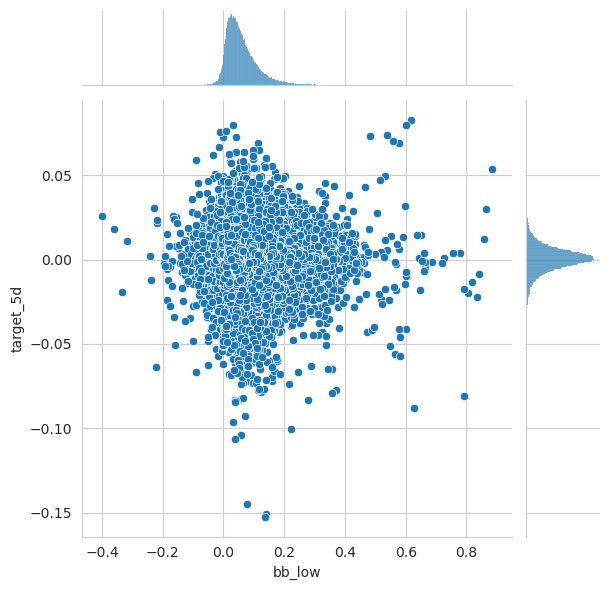

In [326]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

##### ATR

0.06% (84.88%)


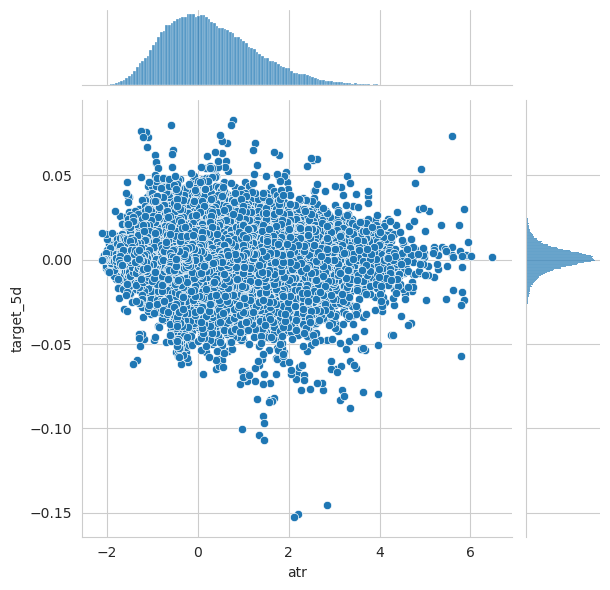

In [327]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

##### MACD

-4.35% (0.00%)


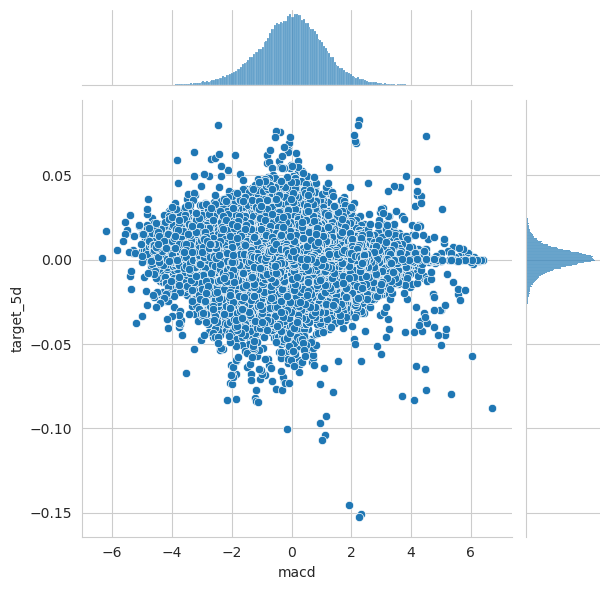

In [328]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')